In [8]:
library(lubridate)
library(tidyverse)
# resolve namespace conflicts
select <- dplyr::select

In [10]:
ebd_raw <- read.csv("../data/ebird/output/ebd_export.csv", header = FALSE, col.names = c("date", "lat", "lon", "count"))

# convert dates from numbers to dates
ebd <- ebd_raw %>%
    mutate(
        date = as_date(date)
    )

glimpse(ebd)

Rows: 469,385
Columns: 4
$ date  <date> 1953-05-17, 1953-06-07, 1954-05-23, 1954-06-15, 1954-06-20, 19…
$ lat   <dbl> 59.01511, 59.01511, 59.01511, 59.01511, 59.01511, 59.01511, 59.…
$ lon   <dbl> 16.1053562, 16.1053562, 16.1053562, 16.1053562, 16.1053562, 16.…
$ count <int> 15, 20, 30, 4, 2, 15, 40, 5, 1, 6, 6, 10, 12, 3, 40, 20, 6, 4, …


### Plot cumulative observation count

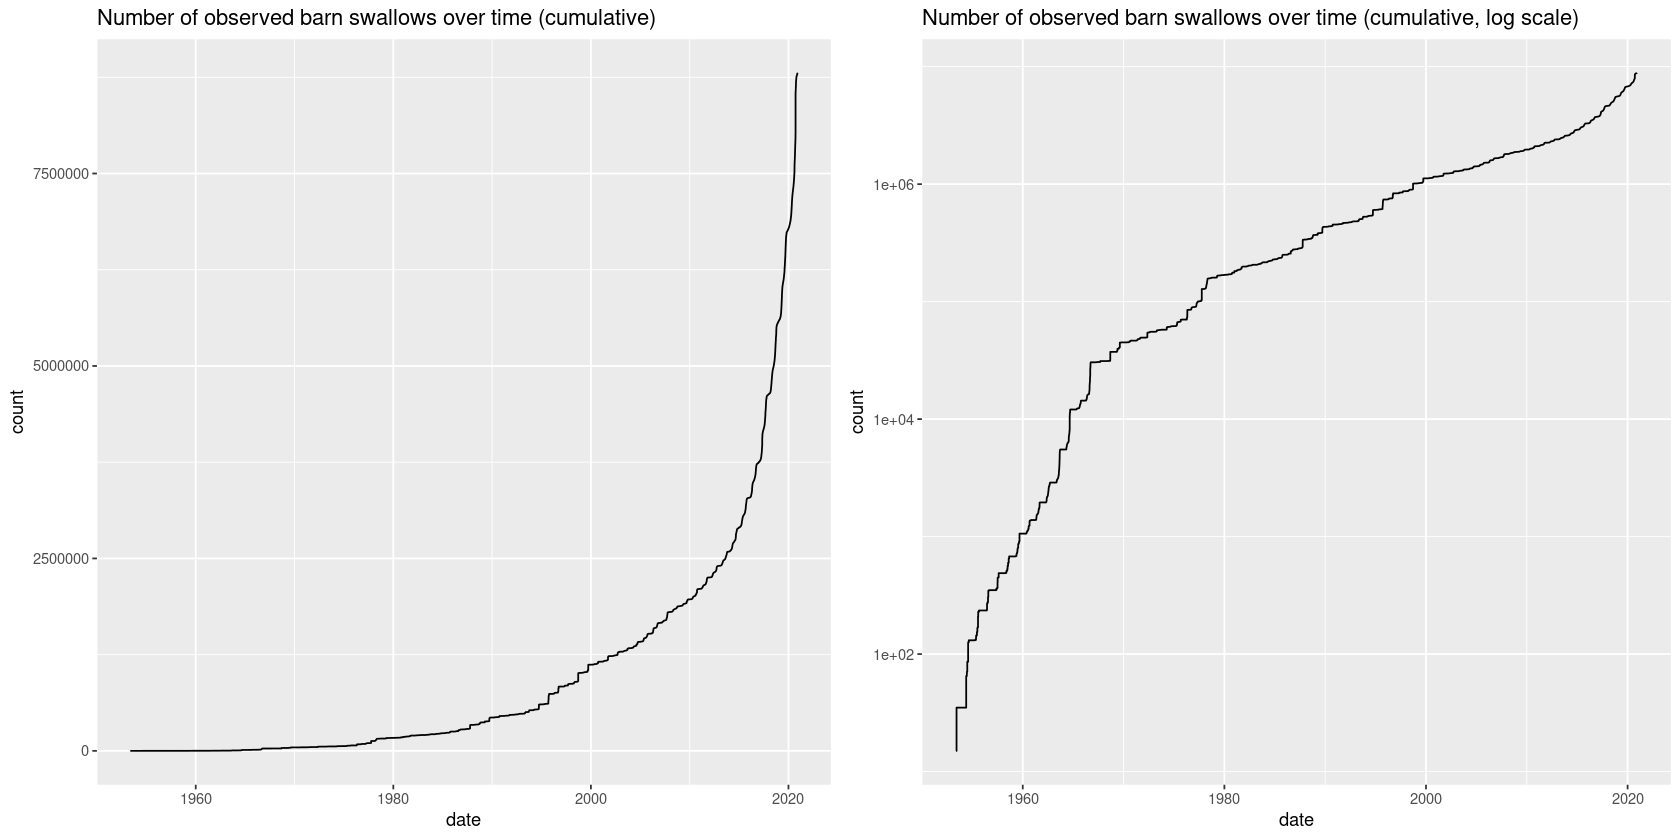

In [46]:
ebd_acc <- ebd %>%
    arrange(as.integer(date)) %>%
    mutate(
        count_acc = accumulate(count, `+`)
    )

plot_linear <- ggplot(ebd_acc) +
    geom_step(aes(x=date, y=count_acc)) +
    ylab("count") +
    labs(title="Number of observed barn swallows over time (cumulative)")

plot_log <- plot_linear + 
    scale_y_log10() +
    labs(title="Number of observed barn swallows over time (cumulative, log scale)")

options(repr.plot.width=14, repr.plot.height=7)
grid.arrange(plot_linear, plot_log, ncol=2)

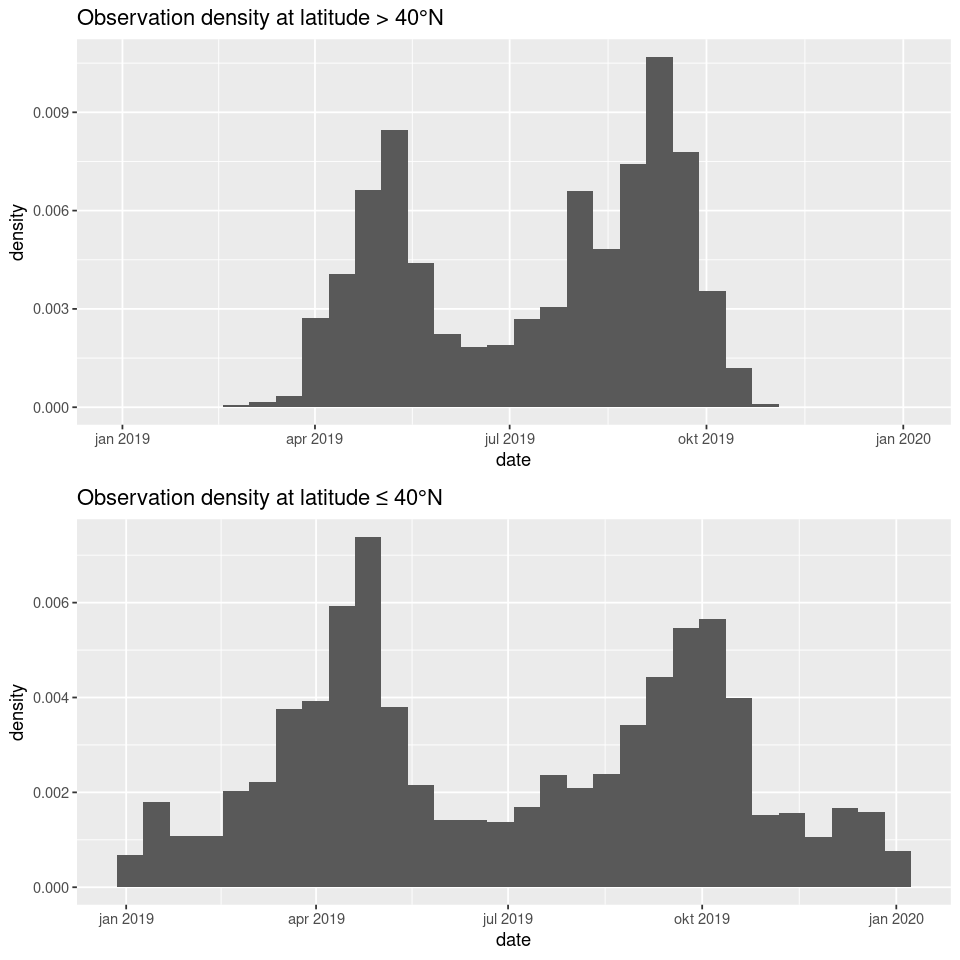

In [56]:
ebd_2019 <- ebd %>% filter(year(date) == 2019)

ebd_north <- ebd_2019 %>%
    filter(lat > 40) %>%
    group_by(date) %>%
    summarize(count_day_sum = sum(count), .groups="drop")

ebd_south <- ebd_2019 %>%
    filter(lat <= 40) %>%
    group_by(date) %>%
    summarize(count_day_sum = sum(count), .groups="drop")

plot_north <- ggplot(ebd_north) +
    geom_histogram(aes(x=date, y=..density.., weight=count_day_sum), bins=30) +
    labs(title="Observation density at latitude > 40°N")

plot_south <- ggplot(ebd_south) +
    geom_histogram(aes(x=date, y=..density.., weight=count_day_sum), bins=30) +
    labs(title="Observation density at latitude ≤ 40°N")

options(repr.plot.width=8, repr.plot.height=8)
grid.arrange(plot_north, plot_south)